In [1]:
from rl_trading_framework import *
from tqdm.notebook import tqdm
from config import *

In [2]:
# fetching data
price_data_all = get_data_torch(tickers, valid_start, valid_end, multiplier, data_freq, device)

getting data:   0%|          | 0/15 [00:00<?, ?it/s]

In [3]:
# instantiate model
state_encoding_model = StateEncodingModel(device, batch_size_valid, input_dim=8, lstm_hidden_dim=lstm_hidden_dim, num_layers=lstm_num_layers).to(device)
trading_policy_model = TradingPolicyModel(lstm_hidden_dim, mlp_hidden_dim, action_dim).to(device)
trading_agent = TradingAgent(state_encoding_model, trading_policy_model)
env = TradingEnvironment(state_encoding_model, reg_rolling_window, batch_size_valid, portfolio_settings, action_dim, device, full_sample_valid, pair_indices_given=[])

# load model paras
load_model_paras(state_encoding_model, model_folder_path, encoding_model_file_name)
load_model_paras(trading_policy_model, model_folder_path, policy_model_file_name)
state_encoding_model.reset_state(batch_size_valid)

In [4]:
# agent trading
env.update_data(price_data_all)
env.reset()
done = False
trajectory = []
action_history = []
port_value_history = [np.array(env.port_value)]
quantity_history = [[(float(x), float(y)) for x, y in zip(env.x_quantity, env.y_quantity)]]

with tqdm(total=env.period_len-reg_rolling_window, desc='agent trading') as pbar:
    while not done:     # for t in range(reg_rolling_window, env.period_len):
        ob_t = env.update_observation()
        encoded_state = state_encoding_model(ob_t)
        env.norm_port_value = (env.port_value / env.bt_settings['initial_cash']).unsqueeze(1)
        action = trading_agent.choose_action(encoded_state, env.norm_port_value, method_in_valid)
        reward, ob_t, done = env.step(action)       # reward not used for now

        action_history.append(np.array(action))
        port_value_history.append(np.array(env.port_value))
        quantity_history.append([(float(x), float(y)) for x, y in zip(env.x_quantity, env.y_quantity)])
        trajectory.append((encoded_state, action, reward))      # trajectory not used for now
        pbar.update(1)

action_history = np.array(action_history)
port_value_history = np.array(port_value_history) / env.bt_settings['initial_cash']
quantity_history = np.array(quantity_history)
pair_names = [f"{tickers[i]}-{tickers[j]}" for i, j in env.pair_indices]

agent trading:   0%|          | 0/3150 [00:00<?, ?it/s]

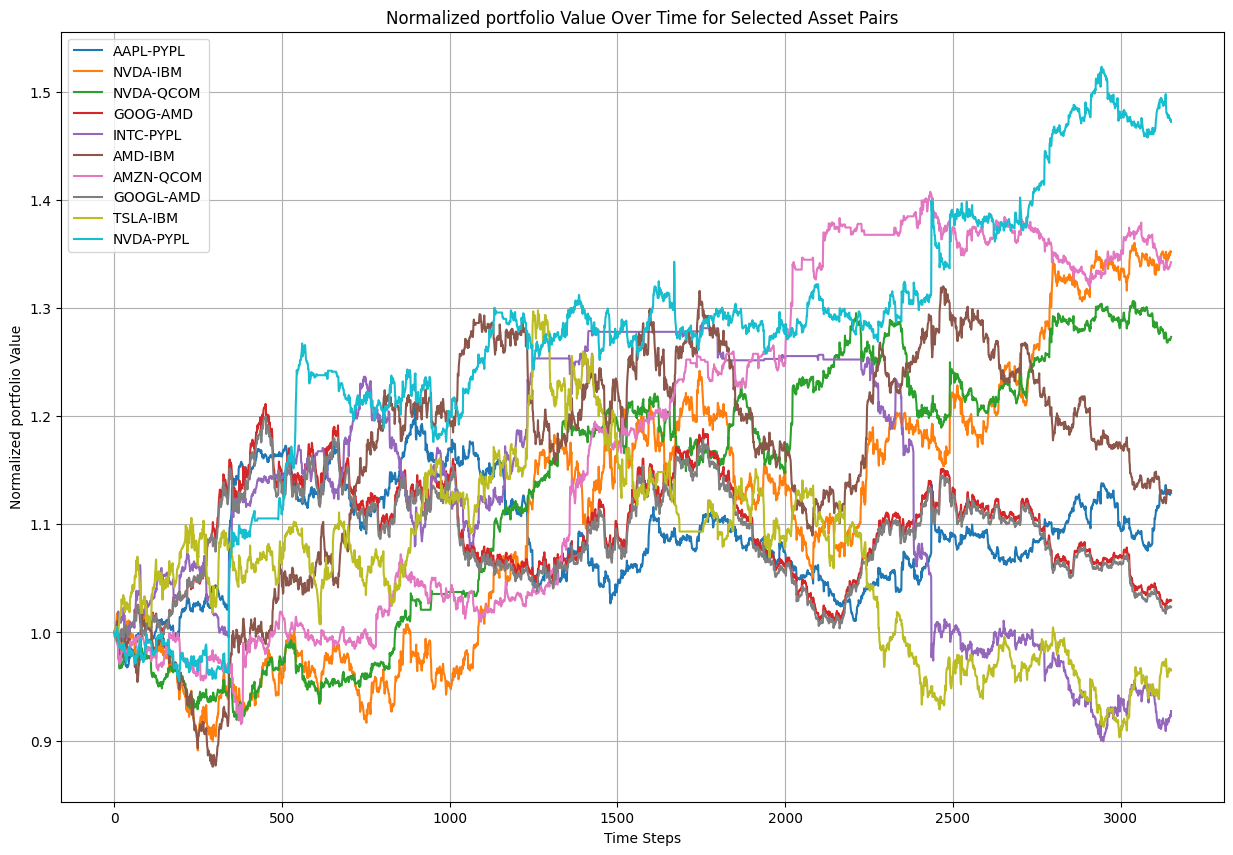

In [5]:
num_quantiles = 10
top_n_pairs_each_quantile = 3
selected_pair_names = plot_and_return_top_pairs(num_quantiles, top_n_pairs_each_quantile, port_value_history, pair_names)

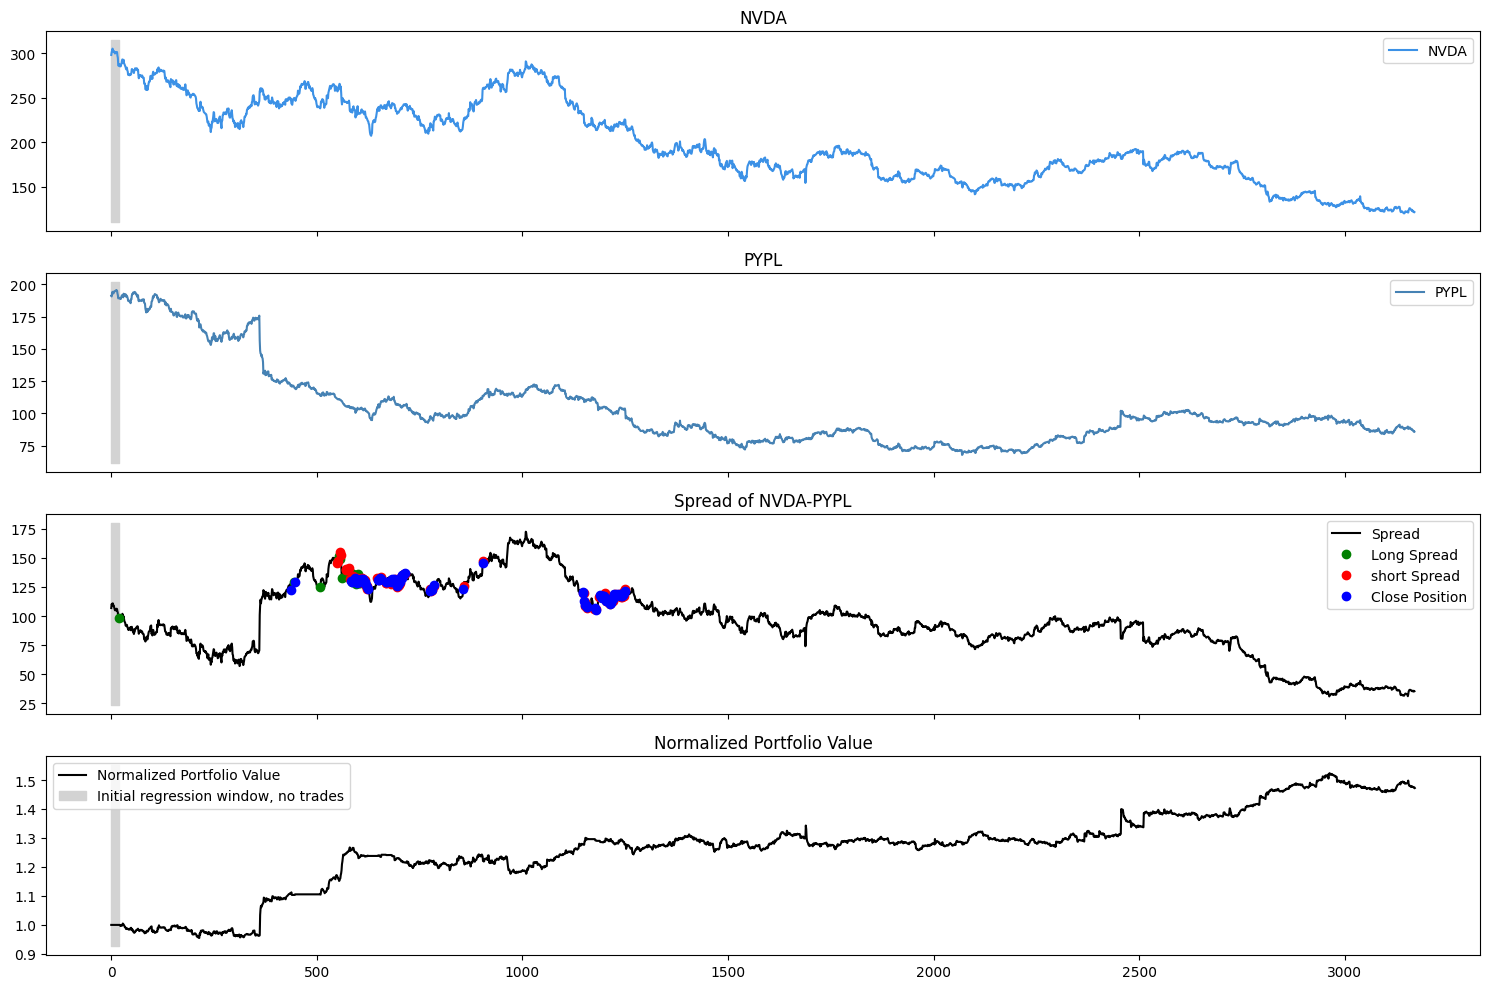

In [11]:
pair_to_plot = 'NVDA-PYPL'
plot_a_pair(pair_to_plot, tickers, env.pair_indices, price_data_all.cpu().numpy(), reg_rolling_window, port_value_history, action_history)

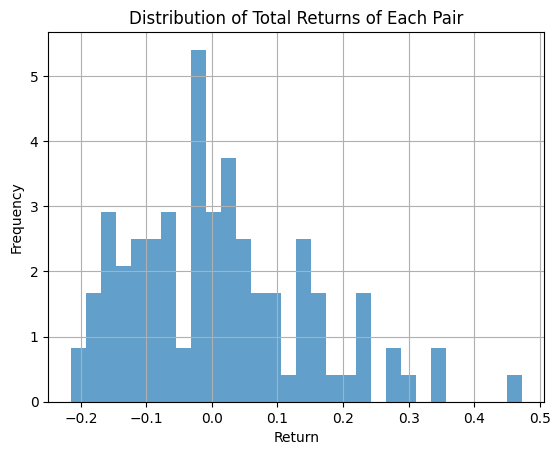

In [7]:
# choices are 'total return of each pair', 'across time steps', and 'all'
plot_return_distribution(port_value_history, choice='total return of each pair', bins=30)

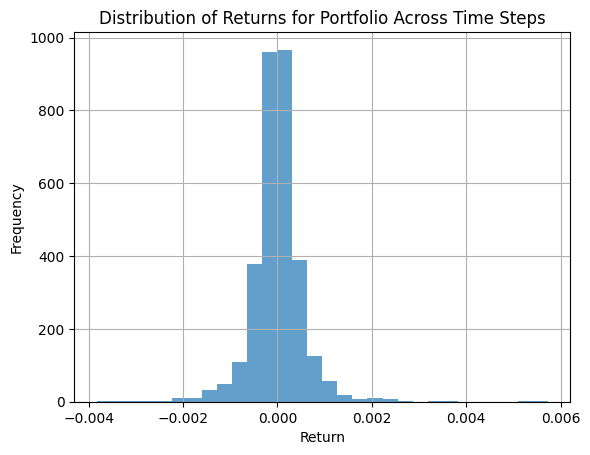

In [8]:
plot_return_distribution(port_value_history, choice='across time steps', bins=30)

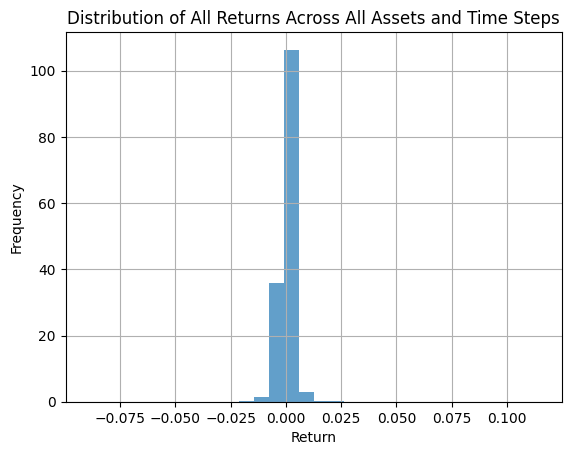

In [9]:
plot_return_distribution(port_value_history, choice='all', bins=30)

In [10]:
selected_pair_names = list(selected_pair_names)
print(selected_pair_names)
%store selected_pair_names

['INTC-PYPL', 'GOOGL-AMD', 'AMZN-QCOM', 'NVDA-QCOM', 'AAPL-PYPL', 'AMD-IBM', 'GOOG-AMD', 'NVDA-PYPL', 'TSLA-IBM', 'NVDA-IBM']
Stored 'selected_pair_names' (list)
